In [ ]:
#Streaming data from Twitter 
!pip install  tweepy 
pip install nltk

In [1]:
import tweepy as tw
consumer_key =   ''# confidential
consumer_secret = '' # confidential
access_token =  ''# confidential
access_token_secret = '' # confidential

In [2]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [3]:
#import relevant libs
import requests
import os
import json
import pandas as pd
import csv
import datetime
import dateutil.parser
import unicodedata
import time
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer



#https://lunarcrush.com/influencers?metric=influencers_influential&symbol=ETH


In [39]:

users = ['elonmusk', 'saylor', 'MicroStrategy', 'BarrySilbert', 'BitcoinMagazine', 'brian_armstrong', 'CoinDesk', 'federalreserve', 'SecYellen', 'GaryGensler']

all_tweets = []
startDate = datetime.datetime(2021,3,4,0,0,0)
endDate = datetime.datetime(2022,3,3,0,0,0)

count_sleep = 0 
    
for i in range(len(users)): 
    user = users[i]
    print("User : ", user)
    tweets = api.user_timeline(user,include_rts = False,tweet_mode = 'extended')
    all_tweets.extend(tweets)
    oldest_id = tweets[-1].id
    while True:
        tweets = api.user_timeline(user,include_rts = False, max_id = oldest_id - 1,tweet_mode = 'extended')
        count_sleep += len(tweets)
        if len(tweets) == 0:
            break
        oldest_id = tweets[-1].id
        all_tweets.extend(tweets)
        tweet = tweets[-1]
        created = tweet.created_at
        if created < startDate: 
            break 
        if count_sleep > 1000: 
            time.sleep(30)
            count_sleep = 0 
        print('N of tweets downloaded till now {}'.format(len(all_tweets)))

User :  elonmusk
N of tweets downloaded till now 20
User :  saylor
N of tweets downloaded till now 58
N of tweets downloaded till now 78
N of tweets downloaded till now 98
N of tweets downloaded till now 118
N of tweets downloaded till now 138
N of tweets downloaded till now 157
N of tweets downloaded till now 177
N of tweets downloaded till now 197
N of tweets downloaded till now 215
N of tweets downloaded till now 235
N of tweets downloaded till now 255
N of tweets downloaded till now 275
N of tweets downloaded till now 295
N of tweets downloaded till now 315
N of tweets downloaded till now 335
N of tweets downloaded till now 355
N of tweets downloaded till now 374
N of tweets downloaded till now 393
N of tweets downloaded till now 412
N of tweets downloaded till now 431
N of tweets downloaded till now 451
N of tweets downloaded till now 468
N of tweets downloaded till now 487
N of tweets downloaded till now 507
N of tweets downloaded till now 527
N of tweets downloaded till now 547


In [133]:
from pandas import DataFrame
outtweets = [[tweet.id_str, 
              tweet.created_at, 
              tweet.favorite_count, 
              tweet.retweet_count, 
              tweet.full_text.encode("utf-8").decode("utf-8")] 
             for idx,tweet in enumerate(all_tweets)]
df = DataFrame(outtweets,columns=["id","created_at","favorite_count","retweet_count", "text"])

df

,id,created_at,favorite_count,retweet_count,text
0,1501796086255693827,2022-03-10 05:44:23,230,21,@WholeMarsBlog @Erdayastronaut @CopSub This we...
1,1501676656867614720,2022-03-09 21:49:49,26432,2332,@FedorovMykhailo @OMarkarova You’re welcome. W...
2,1501674678976450563,2022-03-09 21:41:57,9113,587,"@PPathole @SpaceX Optimized, fully-reusable St..."
3,1501673373813907464,2022-03-09 21:36:46,3802,193,"@Erdayastronaut @CopSub In our experience, COP..."
4,1501641453088518144,2022-03-09 19:29:56,1973,118,@Kristennetten @BBCScienceNews There is no dir...
...,...,...,...,...,...
10072,1420037010979491846,2021-07-27 15:03:01,498,55,ICYMI: Check out our final rulemaking agenda.\...
10073,1419770683744206860,2021-07-26 21:24:43,436,17,@HesterPeirce @swadamske @SECGov Thank you @He...
10074,1419730488089092100,2021-07-26 18:45:00,3381,327,Today is Gurbir Grewal’s first day @SECGov. I ...
10075,1419705259136585729,2021-07-26 17:04:45,1372,105,"I’m animated every day by working families, by..."


In [42]:
df.to_csv('finaldf.csv', index=False)

In [134]:
def time_stamp(date): 
    date = str(date)
    filtered_date = date[:10]
    return filtered_date


def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def prep_data(tweet):
    extra_stopwords = ["The", "It", "it"]
    tweet = re.sub("https?:\/\/\S+", "", tweet)  # replacing url with domain name
    tweet = re.sub("#[A-Za-z0–9]+", " ", tweet)  # removing #mentions
    tweet = re.sub("#", " ", tweet)  # removing hash tag
    tweet = re.sub("\n", " ", tweet)  # removing \n
    tweet = re.sub("@[A-Za-z0–9]+", "", tweet)  # removing @mentions
    tweet = re.sub("RT", "", tweet)  # removing RT
    tweet = re.sub("^[a-zA-Z]{1,2}$", "", tweet)  # removing 1-2 char long words
    tweet = re.sub("\w*\d\w*", "", tweet)  # removing words containing digits
    for word in extra_stopwords:
        tweet = tweet.replace(word, " ")

    
    new_s = remove_emoji(tweet)
    return new_s
    

sia = SentimentIntensityAnalyzer()
def sentiment_analysis_cpd(tweet): 
    return sia.polarity_scores(tweet).get('compound')

def sentiment_analysis_neg(tweet): 
    return sia.polarity_scores(tweet).get('neg')

def sentiment_analysis_neu(tweet): 
    return sia.polarity_scores(tweet).get('neu')

def sentiment_analysis_pos(tweet): 
    return sia.polarity_scores(tweet).get('pos')


df['clean_tweet'] = df['text'].apply(prep_data)
df['created_at'] = df['created_at'].apply(time_stamp)
df['compound'] = df['clean_tweet'].apply(sentiment_analysis_cpd)
df['negative'] = df['clean_tweet'].apply(sentiment_analysis_neg)
df['positive'] = df['clean_tweet'].apply(sentiment_analysis_pos)
df['neutral'] = df['clean_tweet'].apply(sentiment_analysis_neu)
df = df.reset_index().drop(columns=['index', 'id'])
df


,created_at,favorite_count,retweet_count,text,clean_tweet,compound,negative,positive,neutral
0,2022-03-10,230,21,@WholeMarsBlog @Erdayastronaut @CopSub This we...,This weekend,0.0000,0.000,0.000,1.000
1,2022-03-09,26432,2332,@FedorovMykhailo @OMarkarova You’re welcome. W...,You’re welcome. We have also sent power adap...,0.4588,0.000,0.120,0.880
2,2022-03-09,9113,587,"@PPathole @SpaceX Optimized, fully-reusable St...","Optimized, fully-reusable Starship is ~ to s...",0.4588,0.000,0.143,0.857
3,2022-03-09,3802,193,"@Erdayastronaut @CopSub In our experience, COP...","In our experience, COPV gain/pain flattens o...",-0.5233,0.200,0.063,0.736
4,2022-03-09,1973,118,@Kristennetten @BBCScienceNews There is no dir...,re is no direct evidence of that ad being r...,-0.2244,0.058,0.000,0.942
...,...,...,...,...,...,...,...,...,...
10072,2021-07-27,498,55,ICYMI: Check out our final rulemaking agenda.\...,ICYMI: Check out our final rulemaking agenda. ...,-0.1280,0.111,0.071,0.818
10073,2021-07-26,436,17,@HesterPeirce @swadamske @SECGov Thank you @He...,Thank you . I appreciate the warm welcome a...,0.8442,0.000,0.502,0.498
10074,2021-07-26,3381,327,Today is Gurbir Grewal’s first day @SECGov. I ...,Today is Gurbir Grewal’s first day . I look fo...,0.7088,0.000,0.160,0.840
10075,2021-07-26,1372,105,"I’m animated every day by working families, by...","I’m animated every day by working families, by...",0.4404,0.000,0.121,0.879


In [75]:
mean_sentiment = df.groupby('created_at')['compound'].mean()
number_of_daily_tweets = df.groupby('created_at').size()

print("Sentiment Avg of all tweeets : ", mean_sentiment)
print("Number of Tweets Daily: ", number_of_daily_tweets)

Daily Sentiment :  created_at
2021-02-06    0.000000
2021-02-07    0.000000
2021-02-08    0.422317
2021-02-09    0.000000
2021-02-16    0.000000
                ...   
2022-03-06    0.176786
2022-03-07    0.081870
2022-03-08    0.078353
2022-03-09    0.198060
2022-03-10    0.111780
Name: compound, Length: 388, dtype: float64
Daily Number of Tweets :  created_at
2021-02-06      1
2021-02-07      1
2021-02-08      6
2021-02-09      1
2021-02-16      1
             ... 
2022-03-06     22
2022-03-07     87
2022-03-08     80
2022-03-09    121
2022-03-10      5
Length: 388, dtype: int64


In [107]:

df_cpd = mean_sentiment.to_frame()
df_daily = number_of_daily_tweets.to_frame().rename(columns = {'0': 'Number'})
df_tweets = pd.merge(df_cpd, df_daily, how = "inner", on = 'created_at')
df_tweets

,compound,0
created_at,,
2021-02-06,0.000000,1
2021-02-07,0.000000,1
2021-02-08,0.422317,6
2021-02-09,0.000000,1
2021-02-16,0.000000,1
...,...,...
2022-03-06,0.176786,22
2022-03-07,0.081870,87
2022-03-08,0.078353,80


In [ ]:
 #After filtering out 

In [135]:
df

,created_at,favorite_count,retweet_count,text,clean_tweet,compound,negative,positive,neutral
0,2022-03-10,230,21,@WholeMarsBlog @Erdayastronaut @CopSub This we...,This weekend,0.0000,0.000,0.000,1.000
1,2022-03-09,26432,2332,@FedorovMykhailo @OMarkarova You’re welcome. W...,You’re welcome. We have also sent power adap...,0.4588,0.000,0.120,0.880
2,2022-03-09,9113,587,"@PPathole @SpaceX Optimized, fully-reusable St...","Optimized, fully-reusable Starship is ~ to s...",0.4588,0.000,0.143,0.857
3,2022-03-09,3802,193,"@Erdayastronaut @CopSub In our experience, COP...","In our experience, COPV gain/pain flattens o...",-0.5233,0.200,0.063,0.736
4,2022-03-09,1973,118,@Kristennetten @BBCScienceNews There is no dir...,re is no direct evidence of that ad being r...,-0.2244,0.058,0.000,0.942
...,...,...,...,...,...,...,...,...,...
10072,2021-07-27,498,55,ICYMI: Check out our final rulemaking agenda.\...,ICYMI: Check out our final rulemaking agenda. ...,-0.1280,0.111,0.071,0.818
10073,2021-07-26,436,17,@HesterPeirce @swadamske @SECGov Thank you @He...,Thank you . I appreciate the warm welcome a...,0.8442,0.000,0.502,0.498
10074,2021-07-26,3381,327,Today is Gurbir Grewal’s first day @SECGov. I ...,Today is Gurbir Grewal’s first day . I look fo...,0.7088,0.000,0.160,0.840
10075,2021-07-26,1372,105,"I’m animated every day by working families, by...","I’m animated every day by working families, by...",0.4404,0.000,0.121,0.879


In [140]:
df_temp = df.copy()
df_temp

,created_at,favorite_count,retweet_count,text,clean_tweet,compound,negative,positive,neutral
0,2022-03-10,230,21,@WholeMarsBlog @Erdayastronaut @CopSub This we...,This weekend,0.0000,0.000,0.000,1.000
1,2022-03-09,26432,2332,@FedorovMykhailo @OMarkarova You’re welcome. W...,You’re welcome. We have also sent power adap...,0.4588,0.000,0.120,0.880
2,2022-03-09,9113,587,"@PPathole @SpaceX Optimized, fully-reusable St...","Optimized, fully-reusable Starship is ~ to s...",0.4588,0.000,0.143,0.857
3,2022-03-09,3802,193,"@Erdayastronaut @CopSub In our experience, COP...","In our experience, COPV gain/pain flattens o...",-0.5233,0.200,0.063,0.736
4,2022-03-09,1973,118,@Kristennetten @BBCScienceNews There is no dir...,re is no direct evidence of that ad being r...,-0.2244,0.058,0.000,0.942
...,...,...,...,...,...,...,...,...,...
10072,2021-07-27,498,55,ICYMI: Check out our final rulemaking agenda.\...,ICYMI: Check out our final rulemaking agenda. ...,-0.1280,0.111,0.071,0.818
10073,2021-07-26,436,17,@HesterPeirce @swadamske @SECGov Thank you @He...,Thank you . I appreciate the warm welcome a...,0.8442,0.000,0.502,0.498
10074,2021-07-26,3381,327,Today is Gurbir Grewal’s first day @SECGov. I ...,Today is Gurbir Grewal’s first day . I look fo...,0.7088,0.000,0.160,0.840
10075,2021-07-26,1372,105,"I’m animated every day by working families, by...","I’m animated every day by working families, by...",0.4404,0.000,0.121,0.879


In [141]:
def filtered_words(tweet): 
    crypto_words = ['bitcoin', 'btc', 'Bitcoin', 'BTC', 'cryptocurrency', 'crypto', 'market', '$BTC']
    for i in range(len(crypto_words)): 
        if crypto_words[i] in tweet: 
            return True
    return False 

for i in range(len(df_temp)): 
    tweet = df_temp.loc[i, 'clean_tweet']
    if filtered_words(tweet) == False: 
        df_temp.drop(i,inplace=True)


In [142]:
#mean_sentiment = df.groupby('date')['compound'].mean()
number_of_daily_tweets = df_temp.groupby('created_at').size()

#print("Daily Sentiment : ", mean_sentiment)
print("Daily Number of Tweets : ", len(number_of_daily_tweets))

Daily Number of Tweets :  263


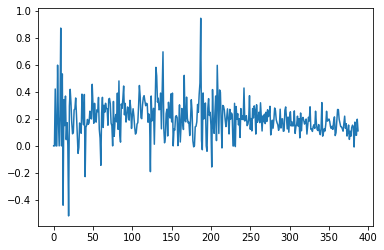

In [143]:
import numpy as np 
import matplotlib.pyplot as plt
x = np.arange(0, len(mean_sentiment))
plt.plot(x, mean_sentiment)

In [ ]:
df.